In [1]:
import numpy as np
from pyei.two_by_two import TwoByTwoEI
from pyei.goodman_er import GoodmansER
from pyei import get_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Demo of models using Santa Clara data

We show examples of using and examining models available in `pyei` using a sample data set:

In [2]:
data = get_data("santaClara.csv")
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
data.head()

,precinct,total_turnout,total2,pct_for_hardy2,pct_for_kolstad2,pct_for_nadeem2,total5,pct_for_caserta5,pct_not_caserta5,pct_for_lacoursiere5,...,pct_for_park5,pct_not_park5,pct_asian_vote,pct_asian_pop,pct_ind_vote,pct_ind_pop,pct_e_asian_vote,pct_e_asian_pop,pct_non_asian_vote,pct_non_asian_pop
0,4201,712,658,0.246201,0.431611,0.322188,642,0.447040,0.552960,0.305296,...,0.247664,0.752336,0.054775,0.117369,0.008427,0.028632,0.046348,0.088736,0.945225,0.882631
1,4208,400,380,0.328947,0.431579,0.239474,379,0.456464,0.543536,0.192612,...,0.350923,0.649077,0.197500,0.214389,0.060000,0.075990,0.137500,0.138399,0.802500,0.785611
2,4211,609,549,0.251366,0.384335,0.364299,542,0.492620,0.507380,0.250922,...,0.256458,0.743542,0.123153,0.202214,0.042693,0.046066,0.080460,0.156147,0.876847,0.797786
3,4215,623,573,0.258290,0.371728,0.369982,558,0.431900,0.568100,0.344086,...,0.224014,0.775986,0.109149,0.162014,0.032103,0.040379,0.077047,0.121635,0.890851,0.837986
4,4217,399,359,0.281337,0.406685,0.311978,355,0.425352,0.574648,0.326761,...,0.247887,0.752113,0.142857,0.254478,0.027569,0.063620,0.115288,0.190859,0.857143,0.745522


## Fitting a modified model from King 1999

This model uses different priors than from King '99: Pareto and uniform hyperparameters are used to perform partial pooling over beta distributions for the groups. The likelihood is the same (binomial) distribution. See, for example [Hierarchical Partial Pooling for Repeated Binary Trials](https://mc-stan.org/rstanarm/articles/pooling.html) for details of this prior structure.

In [3]:
ei = TwoByTwoEI(model_name="king99_pareto_modification")
ei.fit(X, T, N)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting 
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        given demographic group for given candidate is
        0.801
        The posterior mean for the district-level voting preference of
        non-given demographic group for given candidate is
        0.245
        95% Bayesian credible interval for district-level voting preference of
        given demographic group for given candidate is
        [0.62747521 0.92060473]
        95% Bayesian credible interval for district-level voting preference of
        non-given demographic group for given candidate is 
        [0.22430071 0.27208245]
        


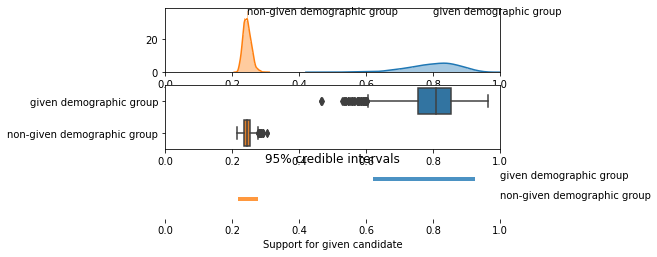

In [4]:
ei.plot();

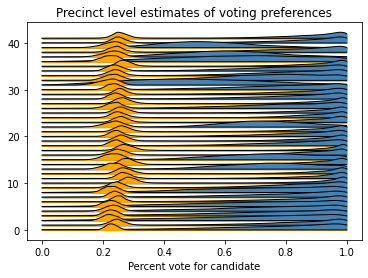

In [5]:
ei.precinct_level_plot();

## Fitting the model from King 1999

This is a faithful representation of the model from King '99: all of the hyperparameters are exponentially distributed with a fixed lambda value. 

In [6]:
ei = TwoByTwoEI(
    "king99", lmbda=0.25
)  # king uses 0.5, but smaller lambdas seem more stable
ei.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99
        Computed from the raw b_i samples by multiplying by population and then getting 
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e asian for Hardy is
        0.851
        The posterior mean for the district-level voting preference of
        non-e asian for Hardy is
        0.237
        95% Bayesian credible interval for district-level voting preference of
        e asian for Hardy is
        [0.65023033 0.97055038]
        95% Bayesian credible interval for district-level voting preference of
        non-e asian for Hardy is 
        [0.21511259 0.2717813 ]
        


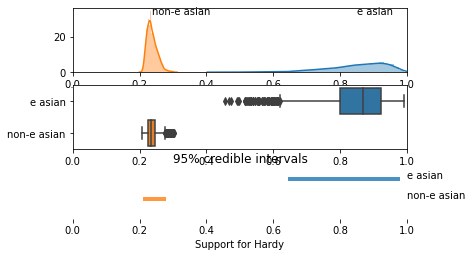

In [7]:
ei.plot();

<AxesSubplot:title={'center':'Precinct level estimates of voting preferences'}, xlabel='Percent vote for candidate'>

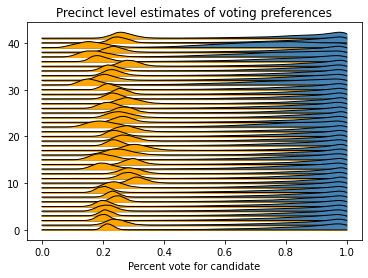

In [8]:
ei.precinct_level_plot()

## Fitting Goodman's ecological regression

In [9]:
goodmans_er = GoodmansER().fit(
    X, T, demographic_group_name="e asian", candidate_name="Hardy"
)
print(goodmans_er.summary())

Goodmans ER
        Est. fraction of e asian
        voters who voted for Hardy is
        0.862
        Est. fraction of non- e asian
        voters who voted for Hardy is
        0.239
        


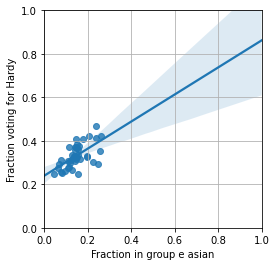

In [10]:
goodmans_er.plot();

## Fitting a weighted version of Goodman's ecological regression

In [11]:
goodmans_er = GoodmansER(is_weighted_regression="True")
goodmans_er.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of e asian
        voters who voted for Hardy is
        0.865
        Est. fraction of non- e asian
        voters who voted for Hardy is
        0.236
        


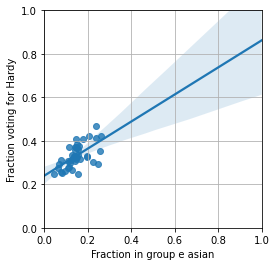

In [12]:
goodmans_er.plot();